# Практическое задание: Оценка IoU, построение кривых качества по коллекции, визуализация
В данном задании Вам предстоит освоить методы оценки качества детекторов и алгоритм подавления немаксимумов.

## Этап 1: Определение и тренировка детектора
<img src="imgs/hog_svm.jpg" width=350 align="right">

В качестве основы для задания возьмем простой детектор HOG + SVM. Детектор использует метод скользящего окна: в каждом окне вычисляется вектор признаков HOG, по которому классификатор на основе SVM отличает окна, содержащие объект, от окон, содержащих фон.

In [86]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imshow
from skimage.feature import hog
from sklearn.svm import SVC
from tqdm import tqdm
%matplotlib inline


class SimpleDetector:
    def __init__(self):
        pass

    def compute_hog(self, X):
        return np.array(list(map(lambda x: hog(x, block_norm='L2-Hys',
                                               pixels_per_cell=(10, 10),
                                               cells_per_block=(4, 2)), X)))

    def fit(self, X, Y):
        self.window_size = X[0].shape[:2]
        hogs = self.compute_hog(X)
        self.model = SVC(probability=True).fit(hogs, Y)
        return self

    def predict(self, X, step=4, prob_threshold=0.0):
        results = []
        for x in tqdm(X):
            crops = []
            bboxes = []
            for i in range(0, x.shape[0] - self.window_size[0], step):
                for j in range(0, x.shape[1] - self.window_size[1], step):
                    crops.append(x[i:i + self.window_size[0],
                                   j:j + self.window_size[1]])
                    bboxes.append(
                        (i, j, self.window_size[0], self.window_size[1]))
            bboxes = np.array(bboxes)
            hogs = self.compute_hog(crops)
            labels = self.model.predict_proba(hogs)
            inds = np.nonzero(labels[:, 1] > prob_threshold)[0]
            results.append(np.hstack((bboxes[inds], labels[inds, 1].reshape(-1, 1))))
        return results

Обучим его на базе _UIUC Image Database for Car Detection_

In [87]:
from skimage.io import imread
from glob import iglob
import os


def load_imgs(img_dir):
    images = {}
    for img_path in iglob(os.path.join(img_dir, '*.pgm')):
        images[os.path.basename(img_path)] = imread(img_path)
    return images


def load_gt(gt_file_path):
    def parse_line(line):
        line_num = int(line.split(': ')[0])
        bbox_lines = line.split(' ')[1:]
        bboxes = []
        for bbox_line in bbox_lines:
            bbox_line = bbox_line.strip('\n()')
            splitted_line = bbox_line.split(',')
            vals = [int(s) for s in splitted_line]
            y, x = vals[:2]
            if len(vals) == 2:
                w, h = 100, 40
            else:
                w = vals[2]
                h = round(40 * w / 100.)
            bboxes.append((y, x, h, w))
        return line_num, bboxes
    lines = open(gt_file_path).readlines()
    gt = {}
    for line in lines:
        line_num, bboxes = parse_line(line)
        gt['test-{}.pgm'.format(line_num)] = bboxes
    return gt

train_data = load_imgs('CarData/TrainImages')
test_data = load_imgs('CarData/TestImages')
test_gt = load_gt('CarData/trueLocations.txt')

Тренировочная база содержит изображения 100x40 автомобилей и различных примеров фона, тестовая база включает в себя изображения разного размера, на которых имеются один или несколько автомобилей схожего с тренировочной выборкой размера.

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


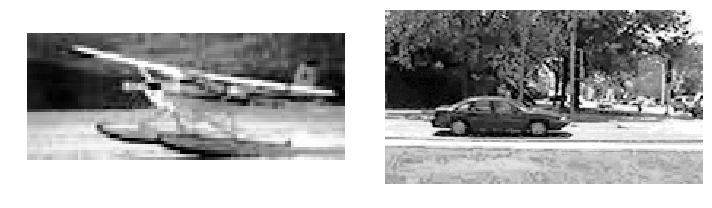

In [88]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.axis('off')
imshow(train_data[list(train_data.keys())[0]])
plt.subplot(1, 2, 2)
plt.axis('off')
imshow(test_data[list(test_data.keys())[0]])
plt.show()

Сформируем ground truth, исходя из названий файлов, а затем протестируем на детектор на выборке.

In [89]:
img_names = list(train_data.keys())
X = [train_data[name] for name in img_names]
Y = [1 if 'pos' in name else 0 for name in img_names]
model = SimpleDetector()
model.fit(X, Y)

In [265]:
img_names = list(test_data.keys())
X = [test_data[name] for name in img_names]
Y = [test_gt[name] for name in img_names]
bboxes = model.predict(X, prob_threshold=0.0)

100%|████████████████████████████████████████| 170/170 [05:35<00:00,  1.80s/it]


## Этап 2. Визуализация результатов работы
<img src="imgs/visualisation.png" width=450 align="right">

Для того, чтобы оценить работу непосредственно на изображениях, применяется визуализация детекций. Для этой задачи удобно использовать библиотеку Python Image Library (PIL). Дополнительно можно другим цветом отмечать правильные обнаружения из ответов тренировочной базы (см. пример справа).

__Задание 1.__ С помощью библиотеки PIL допишите функцию, добавляющую прямоугольники вокруг обнаруженных объектов и уверенность детекции к ним. При визуализации отсеивайте неуверенные ответы, чтобы не засорять изображение.

In [287]:
from PIL import Image, ImageFont, ImageDraw, ImageEnhance

def draw_bboxes(img, bboxes,box_gt,p_inp = 0):
    if (len(img.shape) == 2) or (img.shape[2] == 1):
        img = np.dstack((img, img, img))
    if img.dtype != np.uint8:
        img = (img * 255).astype(np.uint8)
    source_img = Image.fromarray(img)
    p_max = 0
    draw = ImageDraw.Draw(source_img)
    for ind, bbox in enumerate(bboxes):
        x,y,w,h,p = bbox
        list_of_IoU = []
        for i in range(len(box_gt)):
            list_of_IoU.append(IoU(bbox, box_gt[i]))
        if p > p_inp:
            if max(list_of_IoU) > 0.5:
                draw.rectangle([y, x, y+h,x+w],outline="green")
                draw.text((y,x), '{0:.2f}'.format(p), font=ImageFont.truetype("arial.ttf", 12), fill="white")
            else:
                draw.rectangle([y, x, y+h,x+w],outline="red")
                draw.text((y,x), '{0:.2f}'.format(p), font=ImageFont.truetype("arial.ttf", 12), fill="white")
    #print true!
    for bbox in box_gt:
        x,y,w,h = bbox[:4]
        draw.rectangle([y, x, y+h,x+w],outline="white")
        #draw.text((y,x), '{0:.2f}'.format(p), font=ImageFont.truetype("arial.ttf", 12), fill="white")
        if p_inp !=0:
            break
    del draw
    #source_img.save('1234_1.jpeg')
    #imshow()
    return np.array(source_img)

## Этап 3: Подсчет IoU

<img src="imgs/iou_equation.png" width=300 align = "right"> 
На выходе детектора мы получили для каждого входного изображения набор ограничивающих прямоугольников (bounding boxes), вместе с уверенностью в принадлежности каждого к классу "Объект". Для того, чтобы оценить, какие из ответов детектора являются правильными, необходимо для каждого из них подсчитать метрику IoU (Intersection over Union). Метрика вычисляется для двух прямоугольников и служит мерой их похожести. 

__Задание 2.__ Вам необходимо релизовать реализовать функцию подсчета IoU согласно шаблону, приведенному ниже. Формула для вычисления IoU приведена справа.

In [267]:
def IoU(a, b):
    """
    a,b: np.array, a = (x,y,w,h) or a = (x,y,w,h,p), where:
        x,y - coodinates of top left corner of bounding box
        w,h - width and height of bounding box
        p - detection probability
    ---
    output: IoU metrics
    """
    (x1,y1,w1,h1) = a[:4]   
    (x2,y2,w2,h2) = b[:4]
    xInter = max(min(x1+w1,x2+w2)-max(x1, x2),0)
    yInter = max(min(y1+h1,y2+h2)-max(y1, y2),0)
    IoU_metric = xInter*yInter
    return IoU_metric/(h1*w1 + h2*w2 - IoU_metric)


__Задание 3.__ Выберите изображение, на котором есть детекция, IoU которой с правильным ответом:
  1. 0.3 – 0.5
  2. 0.5 – 0.7
  3. 0.8 – 1.0
  
Используя функцию из задания 1, визуализируйте изображение, данную детекцию и правильный ответ.

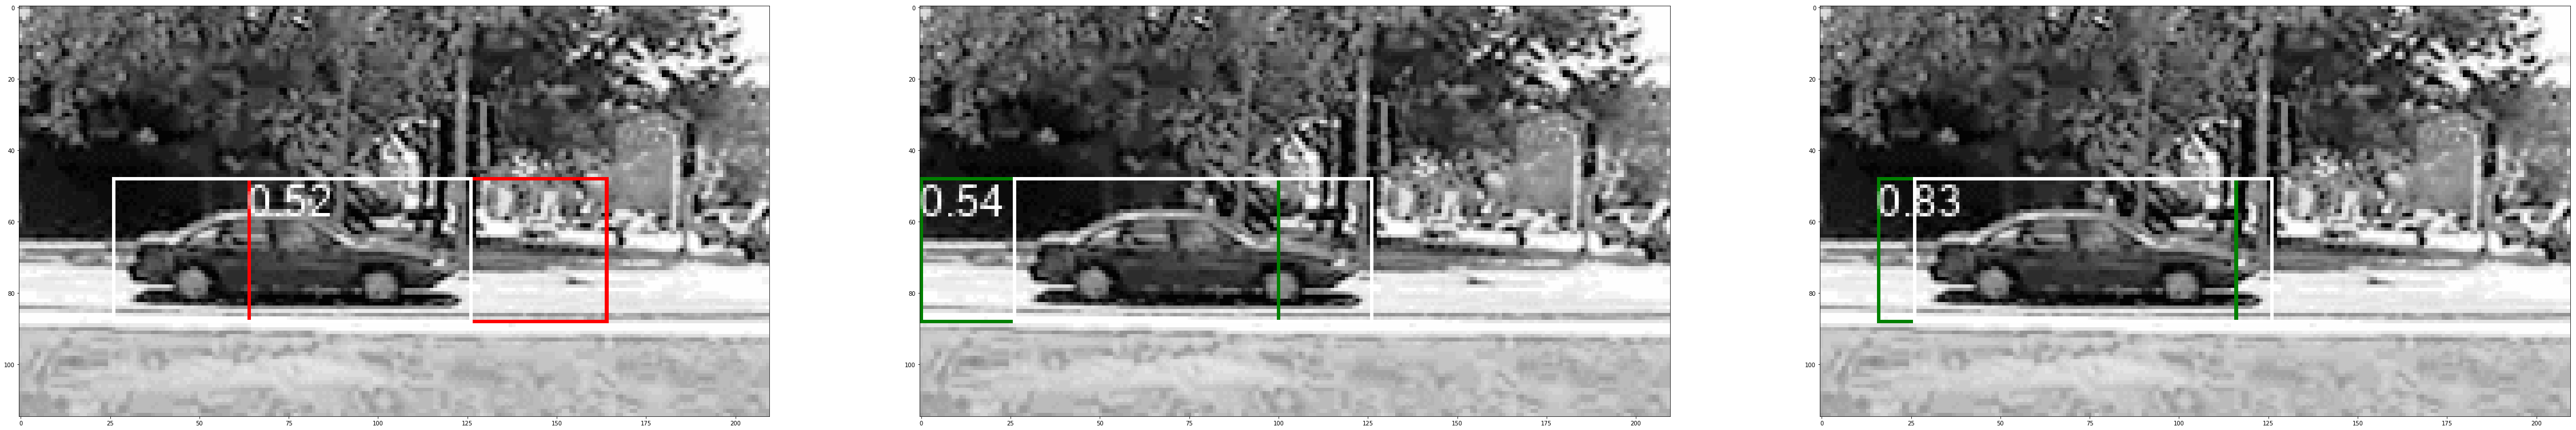

In [288]:
def detection(image,boxes,gt_box,l_gr,r_gr):
    best_model = None
    for box in boxes:
        list_of_IoU = []
        for i in range(len(gt_box)):
            list_of_IoU.append(IoU(box, gt_box[i]))
        m_list = max(list_of_IoU)
        if (m_list > l_gr)and(m_list < r_gr)and(box[4] > 0.5):
            best_model = box
            break
    return best_model
## Your code here
plt.figure(figsize=(80, 20))
plt.axis('off')
list_bool = [False,False,False]
list_box = [0,0,0]
for iter_,bb in enumerate(bboxes):
    if not list_bool[0] :
        best_detect = detection(X[iter_],bb,Y[iter_],0.3,0.5)
        if best_detect is not None:
            list_bool[0] = True
            list_box[0] = [iter_,best_detect]
    if not list_bool[1] :
        best_detect = detection(X[iter_],bb,Y[iter_],0.5,0.7)
        if best_detect is not None:
            list_bool[1] = True
            list_box[1] = [iter_,best_detect]
    if not list_bool[2] :
        best_detect = detection(X[iter_],bb,Y[iter_],0.8,1.0)
        if best_detect is not None:
            list_bool[2] = True
            list_box[2] = [iter_,best_detect]
    if list_bool == [True,True,True]:
        break
for i in range(len(list_box)):
    it = list_box[i][0]
    plt.subplot(1, 3, i+1 )
    listt = [list_box[i][1]]
    #listt.append(np.array(list_box[i][2][0]))
    plt.imshow(draw_bboxes(X[it],listt,Y[it],0.3))
plt.show()

__Задание 4.__ Модифицируйте функцию из задания 1 так, чтобы детекции, близкие к истинным (IoU > 0.5) рисовались другим цветом. Визуализируйте несколько изображений.

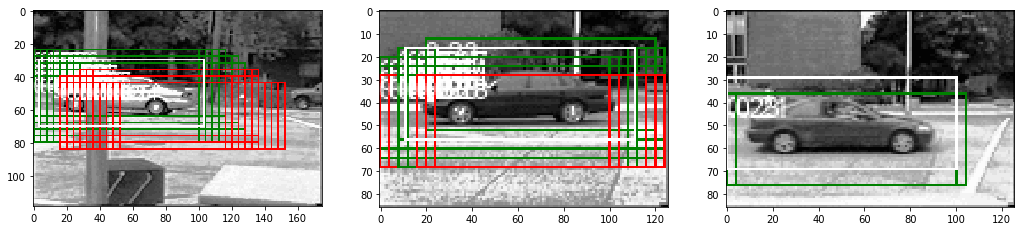

In [298]:
## Your code here
plt.figure(figsize=(30, 12))
plt.axis('off')
for iter_,numb in enumerate(range(len(X))[3:6]):
    plt.subplot(1, 5, iter_+1 )
    plt.imshow(draw_bboxes(X[numb],bboxes[numb] ,Y[numb],0.2))
plt.show()

## Этап 4: Построение Precision-Recall кривой и подсчет AUC
<img src="imgs/pr_equasions.jpg" width=400 align = "right">

На этапе предсказания, SVM-классификатор возвращает вероятность принадлежности каждого окна классу "Объект", детекциями считаются только окна, вышеназванная вероятность которых больше некоторого порога. Варьируя порог, мы можем получить детекторы с различными характеристиками. Множество детекторов, отличающихся только выбором порога, является __семейством детекторов__.

Для оценки качества семейства детекторов часто используют построение кривой Precision-Recall. Рассмотрим двуметрное пространство, одна из координат которого соответствует точности (precision) детектора с определенным порогом, а вторая - полноте (recall). Справа находится напоминание всех необходимых для работы метрик.

Ниже представлен код для рассчета PR-кривой и построение её на плоскости.

In [280]:
from operator import itemgetter
import bisect


def process_bboxes(bboxes, gt, iou_threshold=0.5):
    gt = gt.copy()
    if len(bboxes) > 0:
        bboxes = bboxes[np.argsort(bboxes[:, 4])[::-1], :]

    matched_gt = []
    tp_list = []
    fp_list = []

    for bbox in bboxes:
        if len(gt) == 0:
            fp_list.append(bbox)
            continue

        ms = [IoU(bbox, gt_bbox) for gt_bbox in gt]
        index, element = max(enumerate(ms), key=itemgetter(1))
        if element >= iou_threshold:
            matched_gt.append(gt[index])
            tp_list.append(bbox)
            del gt[index]
        else:
            fp_list.append(bbox)
    not_found_gt = gt
    return tp_list, fp_list, matched_gt, not_found_gt


def compute_PR(tps, fps, gt_count, points_number=1000):
    tpfps = fps
    tpfps.extend(tps)
    tps = sorted(tps)
    tpfps = sorted(tpfps)
    step = max(1, int(len(tps) / points_number))
    tpfps_l = len(tpfps)
    tps_l = len(tps)
    scores = [min(0.0, min(tps))]
    scores.extend([tps[i] for i in range(0, tps_l, step)])

    ans = []
    for score in sorted(scores, reverse=True):
        tpfp_count = tpfps_l - bisect.bisect_right(tpfps, score) + 1
        tp_count = tps_l - bisect.bisect_right(tps, score) + 1
        recall = float(tp_count) / gt_count
        precision = float(tp_count) / tpfp_count
        ans.append((recall, precision, score))
    return ans

Вычислим PR-кривую для нашего семейства.

In [281]:
tps, fps = [], []
gt_count = 0
for b, g in zip(bboxes, Y):
    tp, fp, _, _ = process_bboxes(b, g)
    tps += list([i[4] for i in tp])
    fps += list([i[4] for i in fp])
    gt_count += len(g)
pr = compute_PR(tps, fps, gt_count)

<img src="imgs/pr_plot_example.png" width=300 align="right">

__Задание 5.__ Используя подсчитанную кривую, постройте график precision-recall; Используйте библиотеку matplotlib.pyplot, обязательно подпишите оси и сделайте сетку. Справа показан пример нужного графика.

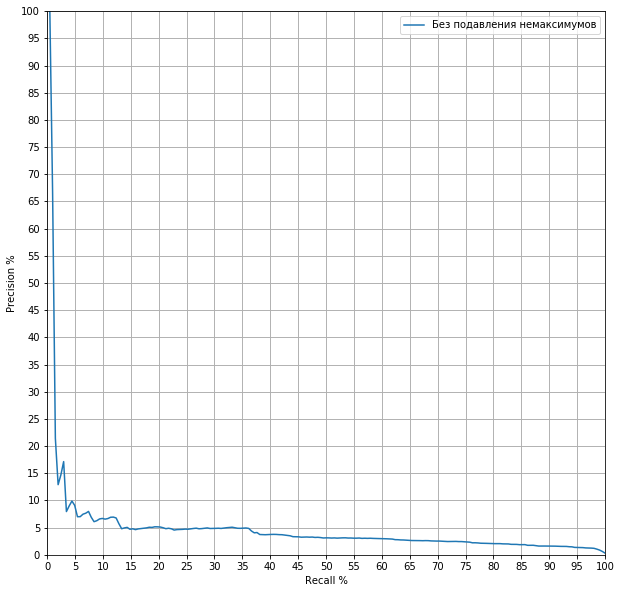

In [300]:
def plot_pr(pr,doppr = None):
    #"""
    #pr - list of tuples (recall, precision, score), sorted by score descend
    #---
    #"""
    fig, ax = plt.subplots(figsize=(10, 10))
    x = []
    y = []
    for i in range(len(pr)):
        x.append(100*(list(pr[i])[0]))
        y.append(100*(list(pr[i])[1]))
    major_ticks = np.arange(0, 101, 5)
    minor_ticks = np.arange(0, 101, 5)
    ax.set_xticks(major_ticks)
    ax.set_xticks(minor_ticks, minor=True)
    ax.set_yticks(major_ticks)
    ax.set_yticks(minor_ticks, minor=True)
    ax.plot(x,y,label = u'Без подавления немаксимумов')
    ax.set_ylabel('Precision %')
    ax.set_xlabel('Recall %')
    ax.set_ylim(ymin=0, ymax=100)
    ax.set_xlim(xmin=0, xmax=100)
    ax.grid(which='both')
    if doppr is not None:
        x2 = []
        y2 = []
        for i in range(len(doppr)):
            x2.append(100*(list(doppr[i])[0]))
            y2.append(100*(list(doppr[i])[1]))
        ax.plot(x2, y2, label = u'Подавление немаксимумов')
    plt.legend()
    plt.show()
    pass
plot_pr(pr)

<img src="imgs/auc_sample.png" width=200 align="right">
В качестве численной меры качества полученной кривой используется площадь под ней (Area Under Curve, AUC). Для расчета AUC достаточно посчитать площади всех трапеций, образованных осью абсцисс, и прямыми, проходящими через точки PR-кривой.

__Задание 6.__ Реализуйте функцию расчета AUC по полученной Precision-Recall кривой согласно шаблону. Подсчитайте AUC для текущей кривой.


In [283]:
def pr_auc(pr):
    """
    pr - list of tuples (recall, precision, score), sorted by score descend
    ---
    output: Area under precision-recall curve
    """
    sq = 0.0
    for i in range(1,len(pr)):
        sq+= (pr[i][1] + pr[i-1][1])*(pr[i][0] - pr[i-1][0])/2
    return sq

print(pr_auc(pr))

0.04362878225263483


## Этап 5. Подавление немаксимумов
<img src="imgs/nms.jpg" width=300 align="right">

Очень часто один и тот же объект может быть обнаружен детектором на разных окнах, в результате чего мы можем наблюдать эффект под названием множественное срабатывание. Для его устранения к ответам детектора применяется алгоритм подавления немаксимумов.

Алгоритм состоит в удалении всех детекций, которые сильно пересекаются с более уверенной детекцией. Для этого можно отсортировать все детекции по убыванию уверенности и, двигаясь по порядку, для каждого неудаленного окна удалить все последующие окна в списке, IoU с которыми больше чем некий порог $t$, обычно $0.3 \leq t \leq 0.7 $

__Задание 7.__ Реализуйте алгоритм подавления немаксимумов согласно шаблону ниже.

In [365]:
def nms(bboxes, iou_thresh):
    """
    bboxes - bounding boxes for one image, array of shape (N,5)
    iou_thresh - threshold for contolling bbox removal
    ---
    output: array of shape (M,5) of suppessed bounding boxes
    """
    sort_pr = np.argsort(bboxes[:,4].flatten())[::-1]
    list_of_box = []
    list_of_box.append(bboxes[sort_pr[0]])
    for iter_pr in sort_pr:
        find = True
        for list_box in list_of_box:
            if IoU(list_box,bboxes[iter_pr]) > iou_thresh:
                find = False
                break;
        if find:
            list_of_box.append(bboxes[iter_pr])
    #print(list_of_box)
    #return np.array([tuple(list_b) for list_b in list_of_box])
    return np.array(list_of_box)

__Задание 8.__ Примените NMS к ответам детектора; постройте на одном графике 2 precision-recall кривых (до и после NMS, не забудьте подписать в легенде), посчитайте и сравните их AUC. Попробуйте подобрать порог $t$ в NMS так, чтобы добиться AUC > 0.5

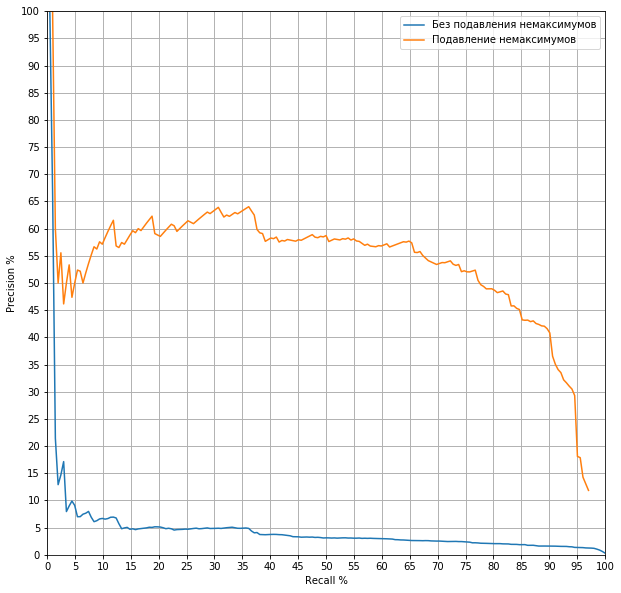

AUC 1: 0.04362878225263483
AUC 2: 0.5240252951313491


In [371]:
## Your code here
tps, fps = [], []
gt_count = 0
for b, g in zip(bboxes, Y):
    tp, fp, _, _ = process_bboxes(b, g)
    tps += list([i[4] for i in tp])
    fps += list([i[4] for i in fp])
    gt_count += len(g)
pr1 = compute_PR(tps, fps, gt_count)
bboxes1 = []
for i in range(len(bboxes)):
    bboxes1.append(nms(bboxes[i], 0.3))
tps, fps = [], []
gt_count = 0
for b, g in zip(bboxes1, Y):
    tp, fp, _, _ = process_bboxes(b, g)
    tps += list([i[4] for i in tp])
    fps += list([i[4] for i in fp])
    gt_count += len(g)
pr2 = compute_PR(tps, fps, gt_count)
plot_pr(pr1,pr2)
print("AUC 1:",pr_auc(pr1))
print("AUC 2:",pr_auc(pr2))

__Задание 9.__ С помощью функции, написанной в задании 1, визуализируйте детекции для нескольких изображений до и после NMS и сравните результаты.

_____________________After NMS_______________________


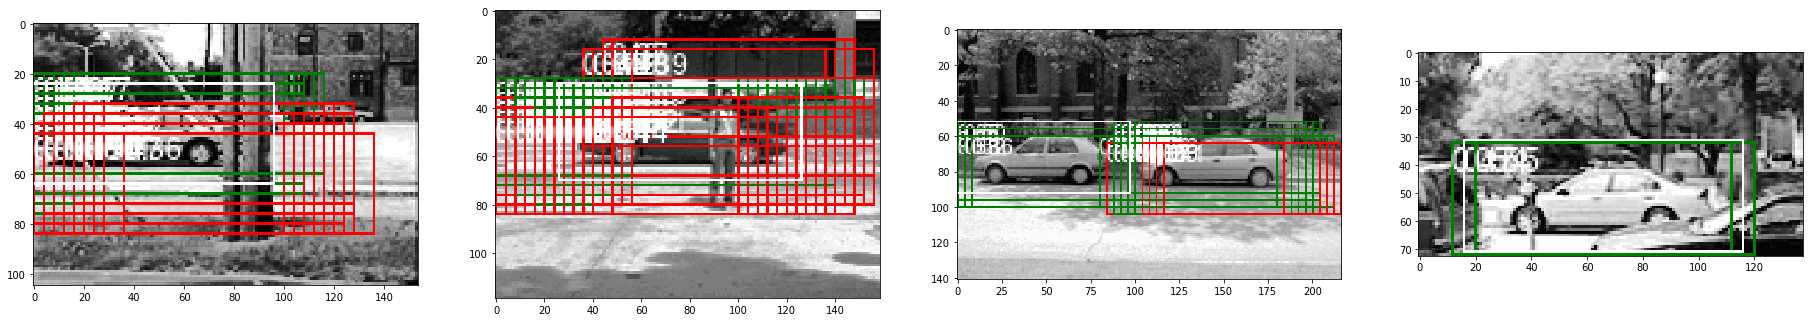

_____________________Before NMS_______________________


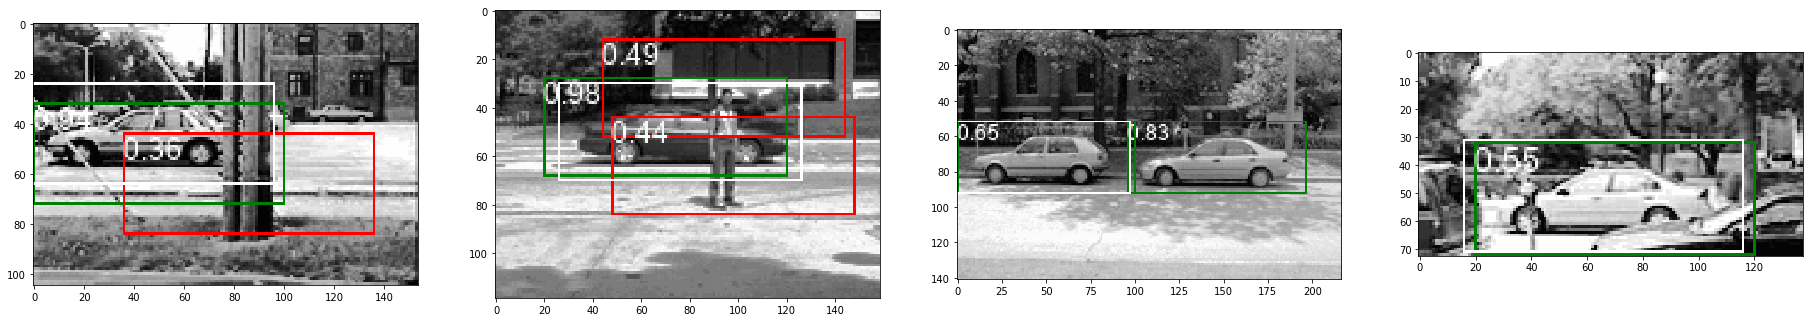

In [372]:
## Your code here
plt.figure(figsize=(40, 20))
plt.axis('off')
#print(bboxes.shape)#.shape)
for iter_,numb in enumerate(range(len(X))[15:19]):
    plt.subplot(1, 5, iter_+1 )
    plt.imshow(draw_bboxes(X[numb],bboxes[numb] ,Y[numb],0.35))
print("_____________________After NMS_______________________")
new_bboxes = []
for i in range(len(bboxes)):
    new_bboxes.append(nms(bboxes[i], 0.3))
plt.show()

print("_____________________Before NMS_______________________")
plt.figure(figsize=(40, 20))
plt.axis('off')
for iter_,numb in enumerate(range(len(X))[15:19]):
    plt.subplot(1,5, iter_+1 )
    plt.imshow(draw_bboxes(X[numb],new_bboxes[numb],Y[numb],0.35))
plt.show()

In [ ]:
Выводы: Из приведенных выше изображений и графиков мы видим, 
что метод подавления немаксимумов сильно сокращает количество некачественных распознаваний объектов.
Следовательно, на оставшихся окнах,как на лучших гипотезах распознавания, мы уже можем делать выводы о типе объекта, 
причем с гораздо большей точностью
(как показано на графиках Precision - Recall для метода детекции без NMS значение AUC составляет всего 0.043, с NMS : 0.51)